In [1]:
import numpy as np
import os
import configparser
from distutils import util

import torch

import sys
sys.path.append('../')
from network import CycleSN
from training_fns import batch_to_cuda, create_synth_batch, CSNDataset
from analysis_fns import (apstarwavegrid, plot_spec_resid_density)

model_name = 'kurucz_to_apogee_22'

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('Using GPU!')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

Load the model configuration

In [2]:
# Directories
csn_dir = '..'
config_dir = os.path.join(csn_dir, 'configs/')
model_dir = os.path.join(csn_dir, 'models/')
progress_dir = os.path.join(csn_dir, 'progress/')
data_dir = os.path.join(csn_dir, 'data/')

# Model configuration
config = configparser.ConfigParser()
config.read(config_dir+model_name+'.ini')
architecture_config = config['ARCHITECTURE']
print('\nCreating model: %s'%model_name)
print('\nConfiguration:')
for key_head in config.keys():
    if key_head=='DEFAULT':
        continue
    print('  %s' % key_head)
    for key in config[key_head].keys():
        print('    %s: %s'%(key, config[key_head][key]))
        
# DATA FILES
data_file_synth = os.path.join(data_dir, config['DATA']['data_file_synth'])
data_file_obs = os.path.join(data_dir, config['DATA']['data_file_obs'])
spectra_norm_file = os.path.join(data_dir, config['DATA']['spectra_norm_file'])
emulator_fn = os.path.join(model_dir, config['DATA']['emulator_fn'])


Creating model: kurucz_to_apogee_22

Configuration:
  DATA
    spectra_norm_file: mean_and_std_PAYNE_specs.npy
    data_file_synth: csn_kurucz.h5
    data_file_obs: csn_apogee.h5
    emulator_fn: PAYNE.pth.tar
  TRAINING
    batchsize: 4
    learning_rate_encoder: 0.0005
    learning_rate_decoder: 0.0005
    learning_rate_discriminator: 0.0005
    loss_weight_rec: 5
    loss_weight_cc: 5
    loss_weight_gen: 1
    loss_weight_dis: 1
    lr_decay_batch_iters_rg: [60e3, 120e3, 180e3, 240e3, 270e3, 300e3]
    lr_decay_batch_iters_dis: [60e3, 120e3, 180e3, 240e3, 270e3, 300e3]
    lr_decay_rg: 0.5
    lr_decay_dis: 0.5
    total_batch_iters: 300e3
    use_real_as_true: False
    mask_synth_lines: False
  ARCHITECTURE
    num_pixels: 7167
    activation: LeakyReLU
    conv_filts_ae_dom: [64, 128, 256, 256]
    conv_filt_lens_ae_dom: [3, 3, 3, 3]
    conv_strides_ae_dom: [2, 2, 2, 2]
    conv_filts_ae_sh: [256, 256]
    conv_filt_lens_ae_sh: [3, 3]
    conv_strides_ae_sh: [2, 2]
    conv_fi

Construct the network architecture

In [3]:
# BUILD THE NETWORKS

print('\nBuilding networks...')
model = CycleSN(architecture_config, emulator_fn, use_cuda=use_cuda)

# Display model architectures
print('\n\nSYNTHETIC EMULATOR ARCHITECTURE:\n')
print(model.emulator)
print('\n\nENCODER_synth and ENCODER_obs ARCHITECTURE:\n')
print(model.encoder_synth)
print('\n\nENCODER_sh ARCHITECTURE:\n')
print(model.encoder_sh)
if model.use_split:
    print('\n\nENCODER_sp ARCHITECTURE:\n')
    print(model.encoder_sp)
    print('\n\nDECODER_sp ARCHITECTURE:\n')
    print(model.decoder_sp)
print('\n\nDECODER_sh ARCHITECTURE:\n')
print(model.decoder_sh)
print('\n\nDECODER_synth and DECODER_obs ARCHITECTURE:\n')
print(model.decoder_synth)
print('\n\nDISCRIM_synth and DISCRIM_obs ARCHITECTURE:\n')
print(model.discriminator_synth)


Building networks...


SYNTHETIC EMULATOR ARCHITECTURE:

Sequential(
  (0): Linear(in_features=25, out_features=300, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=300, out_features=7214, bias=True)
)


ENCODER_synth and ENCODER_obs ARCHITECTURE:

Sequential(
  (0): Conv1d(1, 64, kernel_size=(3,), stride=(2,))
  (1): LeakyReLU(negative_slope=0.1)
  (2): Conv1d(64, 128, kernel_size=(3,), stride=(2,))
  (3): LeakyReLU(negative_slope=0.1)
  (4): Conv1d(128, 256, kernel_size=(3,), stride=(2,))
  (5): LeakyReLU(negative_slope=0.1)
  (6): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
  (7): LeakyReLU(negative_slope=0.1)
)


ENCODER_sh ARCHITECTURE:

Sequential(
  (0): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
  (1): LeakyReLU(negative_slope=0.1)
  (2): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
  (3): LeakyReLU(negative_slope=0.1)
  (4): Conv1d(256, 256,

Load the pre-trained weights for the network

In [4]:
model_filename =  os.path.join(model_dir,model_name+'.pth.tar')

print('\nLoading saved model...')
# Load model info
checkpoint = torch.load(model_filename, map_location=lambda storage, loc: storage)
losses = dict(checkpoint['losses'])

# Load model weights
model.load_state_dict(checkpoint['cycle_model'])


Loading saved model...


<All keys matched successfully>

In [5]:
num_spec = 1000
dataset = 'val' # or 'test'

# Normalization data for the spectra
x_mean, x_std = np.load(spectra_norm_file)

# Load ASPCAP wave-grid
wave_grid = apstarwavegrid()[47:]

mask_synth_lines = bool(util.strtobool(config['TRAINING']['mask_synth_lines']))
if mask_synth_lines:
    print('Using line mask.')
    # Load line mask
    line_mask = np.load(data_dir+'mock_missing_lines.npz')['total_mask']
    line_mask = torch.from_numpy(np.array(line_mask, dtype=np.uint8))
else:
    # Don't use line mask
    line_mask = None

# A set of observed spectra
obs_dataset = CSNDataset(data_file_obs, dataset=dataset, x_mean=x_mean, 
                             x_std=x_std, line_mask=None)
obs_batch = obs_dataset.__getitem__(np.arange(num_spec)) 
# Generate synth batch of matching spectra
synth_batch = create_synth_batch(model, x_mean, x_std, obs_batch['y'], 
                                 line_mask=line_mask, use_cuda=use_cuda)

# Switch to GPU
if use_cuda:
    obs_batch = batch_to_cuda(obs_batch)
    synth_batch = batch_to_cuda(synth_batch)

In [6]:
model.eval_mode()
with torch.no_grad():
    zsh_obs, zsp_obs = model.obs_to_z(obs_batch['x'])

In [ ]:
import torch.nn as nn
from scipy import optimize

# Make module executing the experiment
class Objective(nn.Module):
    def __init__(self, model, x_obs, x_obs_err, x_obs_msk, z_sp=None):
        super(Objective, self).__init__()
        self.model = model
        self.x_obs = x_obs
        self.x_obs_err = x_obs_err
        self.x_obs_msk = x_obs_msk
        self.z_sp = z_sp

    def forward(self, y):
        y = torch.from_numpy(y.astype(np.float32)).view(1,25)
        if use_cuda:
            y = y.cuda()
        with torch.no_grad():
            # Produce synthetic spectrum
            x_synth = model.y_to_synth(y, use_cuda=use_cuda)
            # Normalize the spectrum
            x_synth = (x_synth - x_mean) / x_std
            # Only select last 7167 pixels
            x_synth = x_synth[:,47:]
            # Map to latent-space
            zsh_synth = model.synth_to_z(x_synth)
            # Map to observed domain
            x_synthobs = model.z_to_obs(zsh_synth, self.z_sp)
            return torch.mean(((x_synthobs - self.x_obs)*self.x_obs_msk/self.x_obs_err) ** 2).data.cpu().numpy()
    
# Loop through dataset
y_preds = []
for i in range(len(obs_batch['y'])):
    if i%100==0:
        print(i)
    # Create objective fcn based on the observed spectrum
    objective = Objective(model, obs_batch['x'][i:i+1], obs_batch['x_err'][i:i+1], 
                          obs_batch['x_msk'][i:i+1], z_sp=zsp_obs[i:i+1])
    
    # Use Payne prediction as initial guess
    y0 = obs_batch['y'][i].data.cpu().numpy()
    
    # Run optimization
    res = optimize.minimize(objective, y0, method='BFGS',
                        options={'gtol': 1e-6, 'disp': False,
                                 'maxiter':100})
    
    y_preds.append(res.x)

y_preds = np.concatenate(y_preds)
y_preds = torch.from_numpy(y_preds.astype(np.float32))

0
100
200
300
400
500
600


In [32]:
x_synthobs = create_synth_batch(model, x_mean, x_std, y_preds, 
                                 line_mask=line_mask, use_cuda=use_cuda)

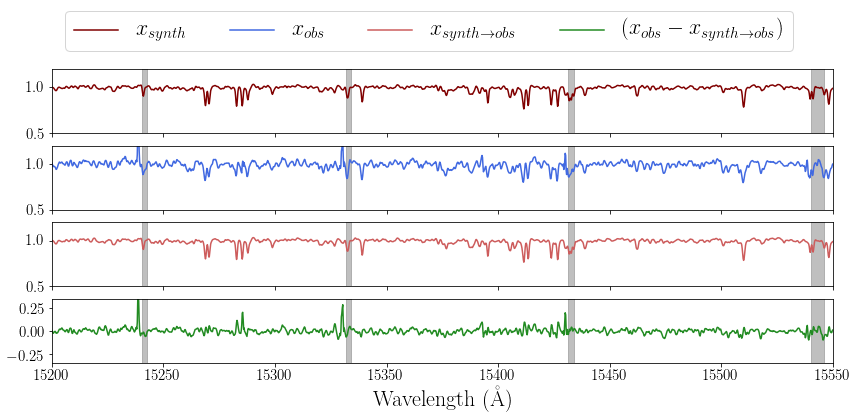

In [35]:
indx = 0
min_wave = 15200 # in Angstroms
max_wave = 15550
plot_sample(wave_grid, (obs_batch['x'][i:i+1]*x_std + x_mean), 
            (synth_batch['x'].detach()[i:i+1]*x_std + x_mean), (synth_batch['x'].detach()[i:i+1]*x_std + x_mean), 
            obs_batch['x_msk'], indx, 
            min_wave=min_wave, max_wave=max_wave, savename=None)